# Training Multiple Models to Obtain Confidence Intervals

In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Linear model code from last time

In [9]:
def make_powers(X, max_power):
    return np.hstack([X ** p for p in range(1, max_power + 1)])

In [11]:
def model(X, W):
    return W[0, :] + X @ W[1:, :]

def dYdW(X):
    return np.insert(X, 0, 1, axis=1)

#Gradient of E with respect to Y
def dEdY(Y, T):
    return -2 * (T - Y)
    
# Gradient of E with respect to W.
def dEdW(X, T, Y):
    result = dEdY(Y, T).T @ dYdW(X) / X.shape[0]
    return result.T

In [13]:
def train(X, T, n_epochs, learning_rate):
    
    means = X.mean(0)
    stds = X.std(0)
    # Replace stds of 0 with 1 to avoid dividing by 0.
    stds[stds == 0] = 1
    Xst = (X - means) / stds
    
    # Xst = np.insert(Xst, 0, 1, axis=1)  # Insert column of 1's as first column in Xst
    
    # n_samples, n_inputs = Xst.shape[0]
    n_samples, n_inputs = Xst.shape
    
    # Initialize weights to all zeros
    W = np.zeros((1 + n_inputs, 1))  # matrix of one column
    
    # Repeat updates for all samples for multiple passes, or epochs,
    for epoch in range(n_epochs):
        
        # Update weights once for each sample.
        for n in range(n_samples):
        
            # Calculate prediction using current model, w.
            Y = model(Xst[n:n + 1, :], W)
            
            # Update w using negative gradient of error for nth sample
            W -= learning_rate * dEdW(Xst[n:n + 1, :], T[n:n + 1], Y)
                
    # Return a dictionary containing the weight matrix and standardization parameters.
    return {'W': W, 'means' : means, 'stds' :stds, 'max_power': max_power}

def use(model, model_parms, X):
    Xst = (X - model_parms['means']) / model_parms['stds']
    Y = model(Xst, model_parms['W'])
    return Y

def rmse(Y, T):
    return np.sqrt(np.mean( (Y - T)**2 ))

# Irregularly Spaced Data

Here is a function of a single variable, $x$, which we will apply to three different spans of $x$ values.

$$ -1 + 10 e^{0.1 x} + 0.1 x^2 - 0.02 x^3 + r$$

where $r$ is from a standard Normal distribution.

In [17]:
n_samples_each_section = 40

ns = n_samples_each_section
X = np.hstack((np.linspace(-8, -5, num=ns),
               np.linspace(0, 3, num=ns),
               np.linspace(6, 10, num=ns))).reshape(3 * ns, 1)
T = -1 + 10 * np.exp(0.1 * X)
T += 0.1 * X**2
T += - 0.02 * X**3
T += 1.0 * np.random.normal(size=(3 * ns, 1))
X.shape, T.shape

((120, 1), (120, 1))

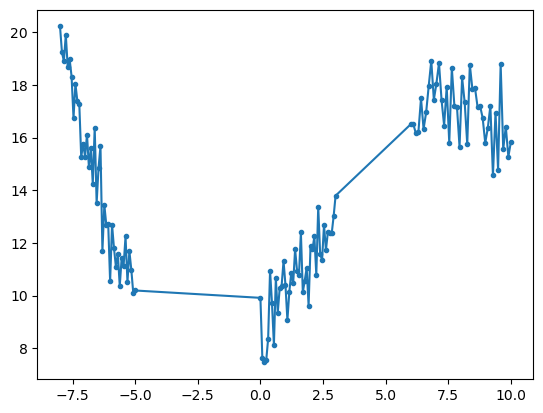

In [19]:
plt.plot(X, T, '.-');

# Divide data into training and testing sets

In [22]:
round(7.8)

8

In [24]:
training_fraction = 0.8

n_rows = X.shape[0]
row_indices = np.arange(n_rows)
np.random.shuffle(row_indices)
n_train = round(n_rows * training_fraction)
n_test = n_rows - n_train

Xtrain = X[row_indices[:n_train], :]
Ttrain = T[row_indices[:n_train], :]
Xtest = X[row_indices[n_train:], :]
Ttest = T[row_indices[n_train:], :]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((96, 1), (96, 1), (24, 1), (24, 1))

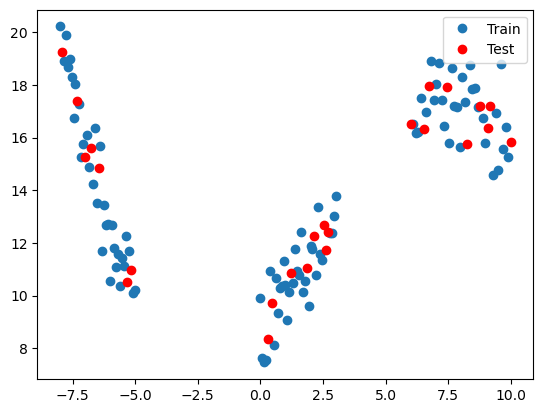

In [26]:
plt.plot(Xtrain[:, 0], Ttrain, 'o', label='Train')
plt.plot(Xtest[:, 0], Ttest, 'ro', label='Test')
plt.legend(loc='best');

# Multiple Models to Estimate Uncertainties and Confidence Intervals


If we train multiple
models from multiple [bootstrap samples](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) of the training data, we can
compute confidence intervals of the weight values.  If zero is
not included in the range of
weight values specified by a weight's 90% lower and
upper confidencce limit, then we can say that we are 90% certain that
the value of this weight is not zero.  If the range does include zero,
the corresponding feature is probably one that is not useful.

Make models based on bootstrap samples of training data.  `models` will be list of models, one for each bootstrap sample.

For each bootstrap sample of our training data we will randomly choose `n_train` samples **with replacement**.  The following code cell illustrates how to create 20 bootstrap samples, each with 10 samples.  The bootstrap samples are defined as row indices.

In [30]:
np.random.choice(list(range(11)), 20)

array([ 7,  1, 10,  3,  0,  9,  7,  7,  9,  3,  2,  3,  9,  2,  4,  4,  5,
        8,  6,  6])

In [32]:
max_power = 1
n_models = 1000
max_power = 1  # linear model

Xtrain = X[row_indices[:n_train], :]
Xtest = X[row_indices[n_train:], :]
Xtrain = make_powers(Xtrain, max_power)
Xtest = make_powers(Xtest, max_power)

n_epochs = 1000
learning_rate = 0.005

n_models = 10

all_model_parms = []
for model_i in range(n_models):
    train_rows = np.random.choice(list(range(n_train)), n_train)
    Xtrain_boot = Xtrain[train_rows, :]
    Ttrain_boot = Ttrain[train_rows, :]
    model_parms = train(Xtrain_boot, Ttrain_boot, n_epochs, learning_rate)
    all_model_parms.append(model_parms)
    print(f'Model {model_i}', end=' ')

Model 0 Model 1 Model 2 Model 3 Model 4 Model 5 Model 6 Model 7 Model 8 Model 9 

In [33]:
len(all_model_parms)

10

In [34]:
all_model_parms[0]

{'W': array([[14.69439533],
        [ 0.44617979]]),
 'means': array([1.43082265]),
 'stds': array([5.96019264]),
 'max_power': 1}

Now we will apply all of the models to the test data.

In [36]:
use(model, all_model_parms[0], Xtest)

array([[14.06326428],
       [14.78307159],
       [14.61031784],
       [14.04023044],
       [14.78883005],
       [15.14393499],
       [15.09018938],
       [15.33588361],
       [14.20146728],
       [14.74852084],
       [14.67941934],
       [15.26678211],
       [14.10357349],
       [15.03644377],
       [14.72548701],
       [14.18995036],
       [15.20535855],
       [14.62183475],
       [15.27446005],
       [14.77731313],
       [14.08053965],
       [15.24374828],
       [15.07483349],
       [13.99416277]])

In [37]:
Y_all = []
for parms in all_model_parms:
    Y_all.append( use(model, parms, Xtest) )

In [38]:
len(Y_all)

10

In [39]:
Y_all[0].shape

(24, 1)

Let's create a `numpy.array` for all outputs of all models so we can easily calculate the mean for each test sample over all models.

In [48]:
np.array(Y_all).shape

(10, 24, 1)

Use `numpy.squeeze` to wring out the "unused" dimension.

In [51]:
np.array(Y_all).squeeze().shape

(10, 24)

In [53]:
Y_all = np.array(Y_all).squeeze().T  # I like putting each model's output in a column, so `Y_all` now has each model's output for a sample in a row.
Ytest = np.mean(Y_all, axis=1)

In [55]:
Ytest.shape

(24,)

In [57]:
RMSE_test = rmse(Ytest, Ttest)
print(f'Test RMSE is {RMSE_test:.4f}')

Test RMSE is 3.1263


In [59]:
n_plot = 200
Xplot = np.linspace(-10, 12, n_plot).reshape(n_plot, 1)
Xplot_powers = make_powers(Xplot, max_power)
Ys = []
for parms in all_model_parms:
    Yplot = use(model, parms, Xplot_powers)
    Ys.append(Yplot)

In [61]:
len(Ys)

10

In [63]:
Ys[0].shape

(200, 1)

In [65]:
np.array(Ys).shape

(10, 200, 1)

In [67]:
Ys = np.array(Ys).squeeze().T
Ys.shape

(200, 10)

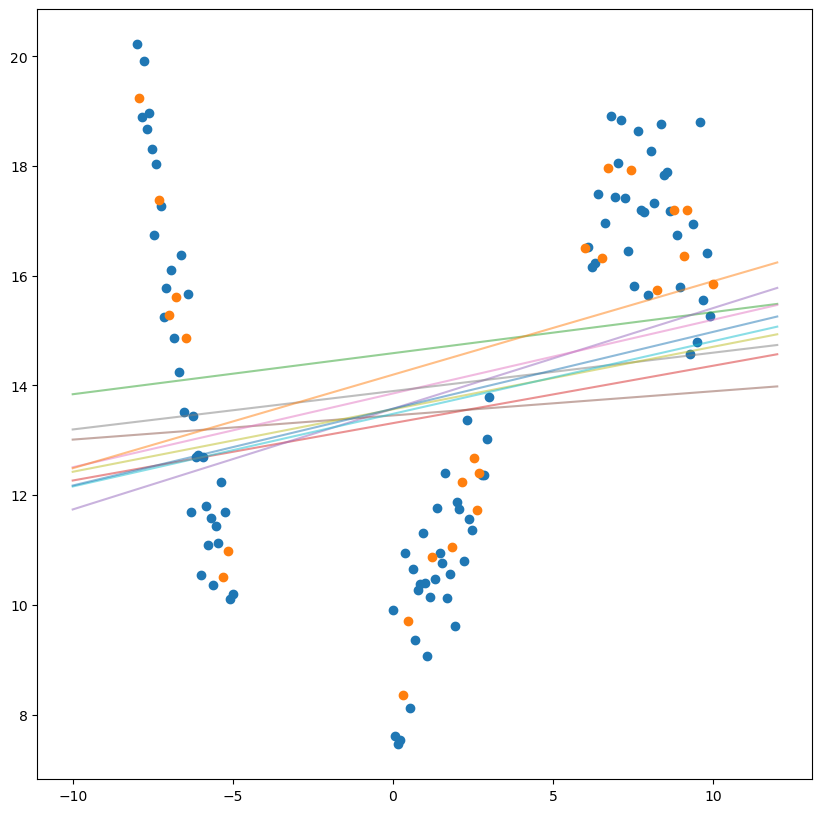

In [69]:
plt.figure(figsize=(10, 10))
plt.plot(Xtrain[:, 0], Ttrain, 'o')
plt.plot(Xtest[:, 0], Ttest, 'o')
plt.plot(Xplot, Ys, alpha=0.5);

Do again with nonlinear terms.

In [72]:
max_power = 8
Xtrain = X[row_indices[:n_train], :]
Xtest = X[row_indices[n_train:], :]
Xtrain = make_powers(Xtrain, max_power)
Xtest = make_powers(Xtest, max_power)

n_epochs = 100
rho = 0.01

n_models = 10

all_model_parms = []
for model_i in range(n_models):
    train_rows = np.random.choice(list(range(n_train)), n_train)
    Xtrain_boot = Xtrain[train_rows, :]
    Ttrain_boot = Ttrain[train_rows, :]
    model_parms = train(Xtrain_boot, Ttrain_boot, n_epochs, rho)
    all_model_parms.append(model_parms)
    print(f'Model {model_i + 1}', end=' ')

Model 1 Model 2 Model 3 Model 4 Model 5 Model 6 Model 7 Model 8 Model 9 Model 10 

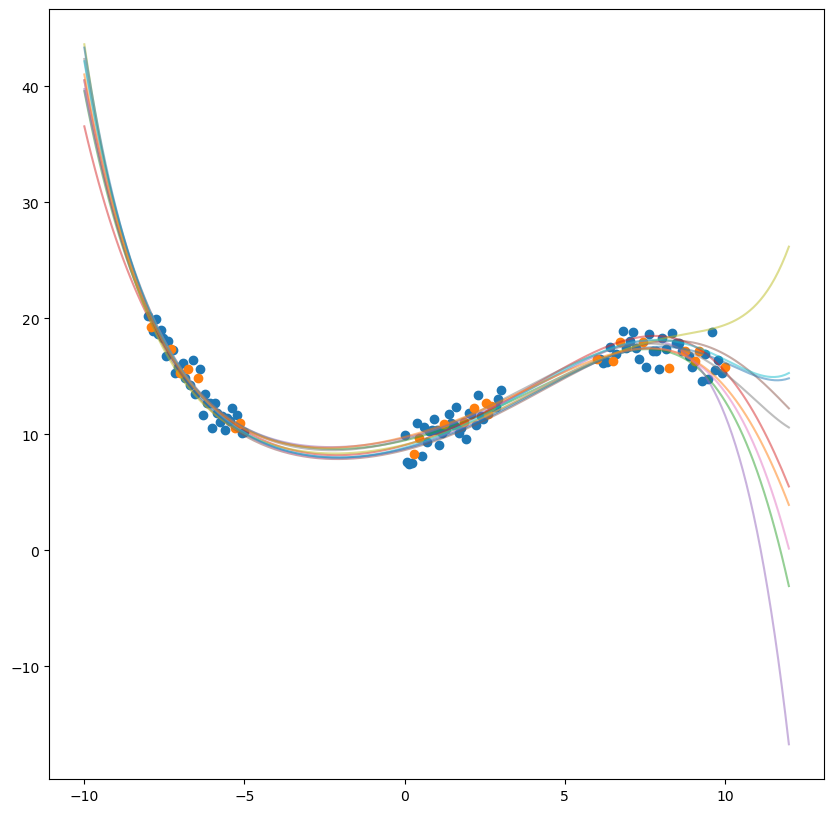

In [74]:
n_xs = 200
Xplot = np.linspace(-10, 12, n_xs).reshape(-1, 1)
Xplot_powers = make_powers(Xplot, max_power)
Ys = []
for parms in all_model_parms:
    Yplot = use(model, parms, Xplot_powers)
    Ys.append(Yplot)

Ys = np.array(Ys).squeeze().T

plt.figure(figsize=(10, 10))
plt.plot(Xtrain[:, 0], Ttrain, 'o')
plt.plot(Xtest[:, 0], Ttest, 'o')
plt.plot(Xplot, Ys, alpha=0.5);

In [76]:
max_power = 8
Xtrain = X[row_indices[:n_train], :]
Xtest = X[row_indices[n_train:], :]
Xtrain = make_powers(Xtrain, max_power)
Xtest = make_powers(Xtest, max_power)

n_epochs = 1000
rho = 0.01

n_models = 100

all_model_parms = []
for model_i in range(n_models):
    train_rows = np.random.choice(list(range(n_train)), n_train)
    Xtrain_boot = Xtrain[train_rows, :]
    Ttrain_boot = Ttrain[train_rows, :]
    model_parms = train(Xtrain_boot, Ttrain_boot, n_epochs, rho)
    all_model_parms.append(model_parms)
    print(f'Model {model_i + 1}', end=' ')

Model 1 Model 2 Model 3 Model 4 Model 5 Model 6 Model 7 Model 8 Model 9 Model 10 Model 11 Model 12 Model 13 Model 14 Model 15 Model 16 Model 17 Model 18 Model 19 Model 20 Model 21 Model 22 Model 23 Model 24 Model 25 Model 26 Model 27 Model 28 Model 29 Model 30 Model 31 Model 32 Model 33 Model 34 Model 35 Model 36 Model 37 Model 38 Model 39 Model 40 Model 41 Model 42 Model 43 Model 44 Model 45 Model 46 Model 47 Model 48 Model 49 Model 50 Model 51 Model 52 Model 53 Model 54 Model 55 Model 56 Model 57 Model 58 Model 59 Model 60 Model 61 Model 62 Model 63 Model 64 Model 65 Model 66 Model 67 Model 68 Model 69 Model 70 Model 71 Model 72 Model 73 Model 74 Model 75 Model 76 Model 77 Model 78 Model 79 Model 80 Model 81 Model 82 Model 83 Model 84 Model 85 Model 86 Model 87 Model 88 Model 89 Model 90 Model 91 Model 92 Model 93 Model 94 Model 95 Model 96 Model 97 Model 98 Model 99 Model 100 

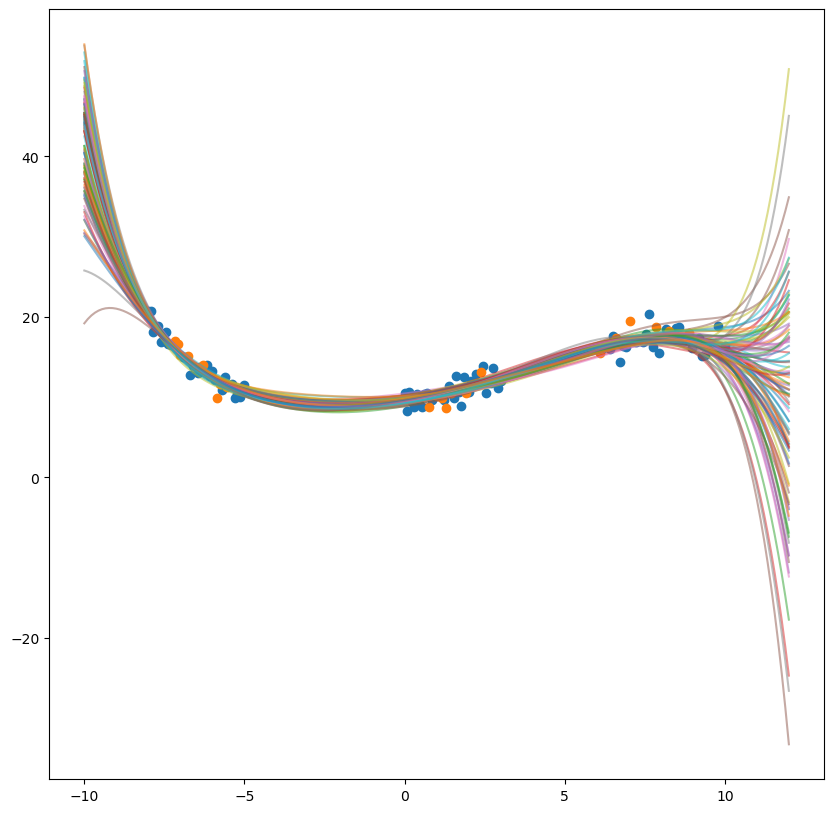

In [142]:
n_xs = 200
Xplot = np.linspace(-10, 12, n_xs).reshape(-1, 1)
Xplot_powers = make_powers(Xplot, max_power)
Ys = []
for parms in all_model_parms:
    Yplot = use(model, parms, Xplot_powers)
    Ys.append(Yplot)

Ys = np.array(Ys).squeeze().T

plt.figure(figsize=(10, 10))
plt.plot(Xtrain[:, 0], Ttrain, 'o')
plt.plot(Xtest[:, 0], Ttest, 'o')
plt.plot(Xplot, Ys, alpha=0.5);

# 90% confidence interval for predictions of all samples.

NameError: name 'models' is not defined

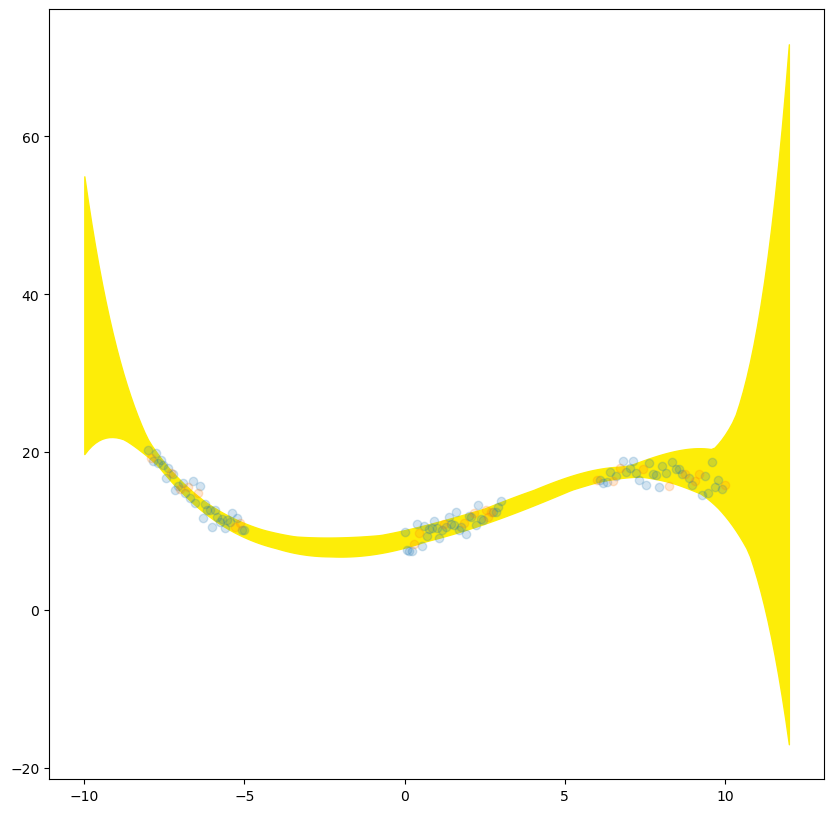

In [77]:
n_plot = 200
Xplot = np.linspace(-10, 12, n_plot).reshape(n_plot, 1)
Xplot_powers = make_powers(Xplot, max_power)
Ys = []
for parms in all_model_parms:
    Yplot = use(model, parms, Xplot_powers)
    Ys.append(Yplot)

Ys = np.array(Ys).squeeze().T

plt.figure(figsize=(10, 10))
plt.plot(Xtrain[:, 0], Ttrain, 'o', alpha=0.2)
plt.plot(Xtest[:, 0], Ttest, 'o', alpha=0.2)

plt.fill_between(Xplot.reshape(-1), Ys.min(axis=-1), Ys.max(axis=-1),
                color='#fded08')

middle = len(models) // 2
plt.plot(Xplot, Ys[:, middle]);

# Confidence intervals of the weights

Now to evaluate the significance of each input by considering the weights on each input across the models. Let's say we want the 90% confidence interval. First, let's collect the weights.

In [ ]:
all_Ws = [model['W'] for model in models]
len(all_Ws), all_Ws[0].shape

In [ ]:
np.array(all_Ws).shape

In [ ]:
all_Ws = np.array(all_Ws).squeeze()
all_Ws.shape

Now we must sort the weight values independently for each input to find the 5% and 95% quantile values.

In [ ]:
Z = np.random.randint(-10, 10, size=50).reshape(10, 5)
Z

In [ ]:
np.sort(Z)

In [ ]:
Z

In [ ]:
np.sort(Z, axis=0)

There we go.

In [ ]:
all_Ws = np.sort(all_Ws, axis=0)
low_high = all_Ws[[4, 94], :].T
low_high

In [ ]:
for i, row in enumerate(low_high):
    if i == 0:
        print(f'Bias w   Low {row[0]:6.2f} High {row[1]:6.2f}')
    else:
        print(f'Power {i + 1:2} Low {row[0]:6.2f} High {row[1]:6.2f}')

So, for which features (max power value) does the 90% confidence interval include 0?  These we can discard.

We used SGD to train these models.  I wonder how the results would differ if we trained with AdamW.